# Arabic Handwritten Characters recognition

   ## Importing the necessary libraries


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tflearn
import matplotlib.pyplot as plt
import seaborn as sns
import tflearn.data_utils as du
import random

from tflearn.data_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.


## Loading the dataset

In [3]:
train_data = pd.read_csv('./dataset/csvTrainImages 13440x1024.csv', header = None)
train_label = pd.read_csv('./dataset/csvTrainLabel 13440x1.csv', header = None)
test_data = pd.read_csv('./dataset/csvTestImages 3360x1024.csv', header = None)
test_label = pd.read_csv('./dataset/csvTestLabel 3360x1.csv', header = None)


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB


In [5]:
train_label.head()

,0
0,1
1,1
2,1
3,1
4,1


In [6]:
train_data = train_data.values.astype('float32')
train_label = train_label.values.astype('int32')-1
test_data = test_data.values.astype('float32')
test_label = test_label.values.astype('int32')-1

In [7]:
train_label[0]

array([0], dtype=int32)

## Data preprocessing 
###  Encoding categorical variables

In [240]:
original_train_label = train_label
train_label = to_categorical(train_label,28)

original_test_label = test_label
test_label = to_categorical(test_label, 28)

In [242]:
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(13440, 1024) (13440, 28) (3360, 1024) (3360, 28)


## Data reshape

In [244]:
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

In [247]:
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(13440, 32, 32, 1) (13440, 28) (3360, 32, 32, 1) (3360, 28)


## Visualizing the dataset

In [249]:
def disply_image(data):

    arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
    
    x = random.randint(0, 13440)
    plt.imshow(data[x].squeeze().T)
    plt.title(arabic_labels[original_train_label[x][0]])

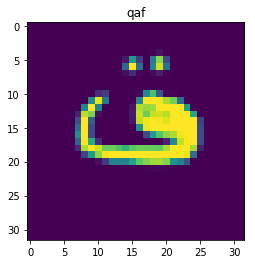

In [250]:
disply_image(train_data)

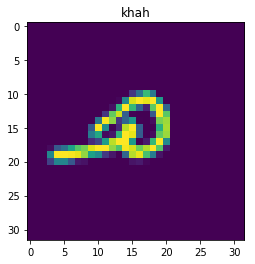

In [252]:
disply_image(test_data)

### Normalizarion

In [10]:
train_data = train_data/255
test_data = test_data/255

In [13]:
train_data, mean1 = du.featurewise_zero_center(train_data)
test_data, mean2 = du.featurewise_zero_center(test_data)

## Building the CNN


In [14]:
recognizer = Sequential()

recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Flatten())
recognizer.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
recognizer.add(Dense(units = 256, activation = "relu"))
recognizer.add(Dropout(0.5))
recognizer.add(Dense(28, activation = "softmax"))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### A summary of the CNN


In [15]:
recognizer.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [16]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [17]:
recognizer.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [19]:
datagen.fit(train_data)

## Fitting the CNN to the training data

In [20]:
recognizer.fit_generator(datagen.flow(train_data,train_label, batch_size=100),epochs = 30, verbose = 2, steps_per_epoch=train_data.shape[0] // 100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
 - 44s - loss: 93.3018 - acc: 0.0275
Epoch 2/30
 - 43s - loss: 93.3017 - acc: 0.0448
Epoch 3/30
 - 43s - loss: 93.3018 - acc: 0.0448
Epoch 4/30
 - 43s - loss: 93.3018 - acc: 0.0970
Epoch 5/30
 - 43s - loss: 93.3018 - acc: 0.0896
Epoch 6/30
 - 43s - loss: 93.3018 - acc: 0.0970
Epoch 7/30
 - 43s - loss: 93.3018 - acc: 0.0896
Epoch 8/30
 - 43s - loss: 93.3018 - acc: 0.0746
Epoch 9/30
 - 43s - loss: 93.3018 - acc: 0.0672
Epoch 10/30
 - 43s - loss: 93.3018 - acc: 0.0672
Epoch 11/30
 - 43s - loss: 93.3018 - acc: 0.1493
Epoch 12/30
 - 43s - loss: 93.3018 - acc: 0.0896
Epoch 13/30
 - 43s - loss: 93.3018 - acc: 0.0746
Epoch 14/30
 - 43s - loss: 93.3018 - acc: 0.1045
Epoch 15/30
 - 43s - loss: 93.3018 - acc: 0.0746
Epoch 16/30
 - 43s - loss: 93.3018 - acc: 0.0522
Epoch 17/30
 - 43s - loss: 93.3018 - acc: 0.1045
Epoch 18/30
 - 43s - loss: 93.3018 - acc: 0.1567
Epoch 19/30
 - 43s - loss: 93.301

## Making the predictions

In [21]:
predictions = recognizer.predict(test_data)
predictions = np.argmax(predictions,axis = 1)


## Generating a confusion matrix

In [22]:
cm = confusion_matrix(test_label, predictions)

## Calculating the accuracy¶


In [23]:
accuracy = sum(cm[i][i] for i in range(28)) / test_label.shape[0]
print("accuracy = " + str(accuracy))

accuracy = 0.03571428571428571
